In [62]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,GRU
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tensorflow.keras import optimizers, Model
import matplotlib.pyplot as plt
import math

# Load Data

In [63]:
import os
CURR_FOLDER_PATH = os.getcwd()
BASE_PATH = os.path.dirname(os.path.dirname(CURR_FOLDER_PATH))
DATA_PATH = os.path.join(BASE_PATH, 'Lulus/data')

In [64]:
df = pd.read_excel(DATA_PATH + '/Harga cabai gabungan lag-3.xlsx')
# Data yang digunakan yaitu Harga cabai Rawit dan Harga Bawang putih sebagai Barang Subtitusi Sudah dilakukan lag - 1 Minggu

In [65]:
df

,Tanggal,Harga Cabai Rawit,Harga Cabai Merah
0,01/ 01/ 2018,24750,-
1,08/ 01/ 2018,26200,38300
2,15/ 01/ 2018,-,42800
3,22/ 01/ 2018,-,37850
4,29/ 01/ 2018,42600,38950
...,...,...,...
308,27/ 11/ 2023,75900,80250
309,04/ 12/ 2023,75250,94900
310,11/ 12/ 2023,76600,99300
311,18/ 12/ 2023,79150,85000


# Statistical Analytics

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Tanggal            313 non-null    object
 1   Harga Cabai Rawit  313 non-null    object
 2   Harga Cabai Merah  313 non-null    object
dtypes: object(3)
memory usage: 7.5+ KB


In [67]:
df.shape

(313, 3)

In [68]:
df.replace('-', pd.NA, inplace=True)

In [69]:
missing_values = df.isnull().sum()
percentage_missing = (missing_values / df.shape[0]) * 100
print("Jumlah Missing Value per Kolom:")
print(missing_values)
print("\nPersentase Missing Value per Kolom:")
percentage_missing

Jumlah Missing Value per Kolom:
Tanggal              0
Harga Cabai Rawit    9
Harga Cabai Merah    9
dtype: int64

Persentase Missing Value per Kolom:


Tanggal              0.000000
Harga Cabai Rawit    2.875399
Harga Cabai Merah    2.875399
dtype: float64

In [70]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/ %m/ %Y')
df['Bulan'] = df['Tanggal'].dt.to_period('M')
mean_values = df.groupby('Bulan').mean()


def fill_missing_with_mean(row):
    if pd.isna(row['Harga Cabai Merah']):
        row['Harga Cabai Merah'] = mean_values.loc[row['Bulan'], 'Harga Cabai Merah']
    if pd.isna(row['Harga Cabai Rawit']):
        row['Harga Cabai Rawit'] = mean_values.loc[row['Bulan'], 'Harga Cabai Rawit']
    return row


df = df.apply(fill_missing_with_mean, axis=1)
print(df)

       Tanggal  Harga Cabai Rawit  Harga Cabai Merah    Bulan
0   2018-01-01       24750.000000       39475.000000  2018-01
1   2018-01-08       26200.000000       38300.000000  2018-01
2   2018-01-15       31183.333333       42800.000000  2018-01
3   2018-01-22       31183.333333       37850.000000  2018-01
4   2018-01-29       42600.000000       38950.000000  2018-01
..         ...                ...                ...      ...
308 2023-11-27       75900.000000       80250.000000  2023-11
309 2023-12-04       75250.000000       94900.000000  2023-12
310 2023-12-11       76600.000000       99300.000000  2023-12
311 2023-12-18       79150.000000       85000.000000  2023-12
312 2023-12-25       79100.000000       93066.666667  2023-12

[313 rows x 4 columns]


In [71]:
df['Harga Cabai Merah'] = df['Harga Cabai Merah'].astype('float64')
df['Harga Cabai Rawit'] = df['Harga Cabai Rawit'].astype('float64')

In [72]:
import seaborn as sns

harga_merah_stats = df['Harga Cabai Merah'].describe()
print("\nStatistik Deskriptif Harga Cabai Merah:")
print(harga_merah_stats)


harga_rawit_stats = df['Harga Cabai Rawit'].describe()
print("\nStatistik Deskriptif Harga Cabai Rawit:")
print(harga_rawit_stats)



Statistik Deskriptif Harga Cabai Merah:
count       313.000000
mean      43092.092652
std       15493.651894
min       21750.000000
25%       31650.000000
50%       40800.000000
75%       49550.000000
max      109450.000000
Name: Harga Cabai Merah, dtype: float64

Statistik Deskriptif Harga Cabai Rawit:
count       313.000000
mean      44580.804047
std       17206.321100
min       22600.000000
25%       30500.000000
50%       41500.000000
75%       53800.000000
max      100750.000000
Name: Harga Cabai Rawit, dtype: float64


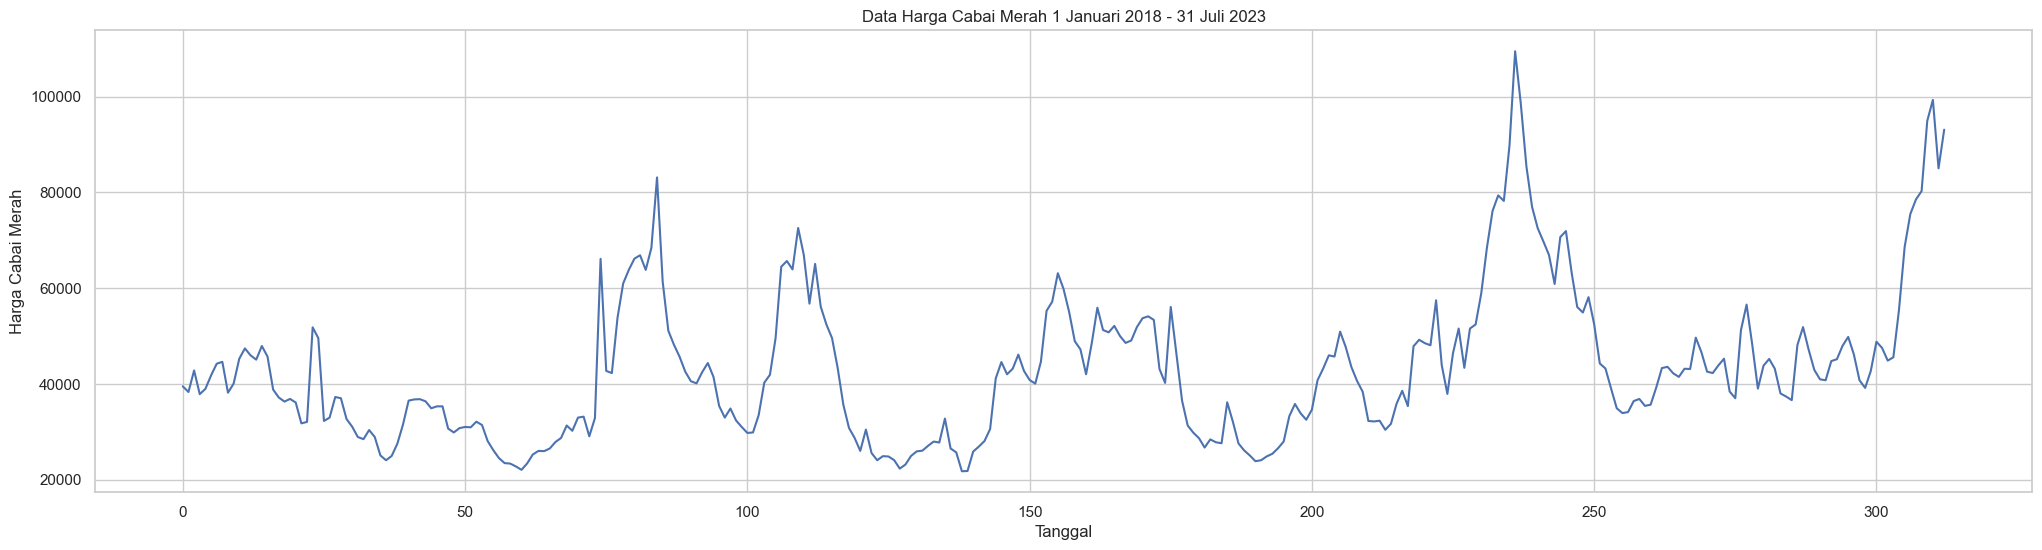

In [73]:
# Visualisasi
plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Harga Cabai Merah'])
plt.title('Data Harga Cabai Merah 1 Januari 2018 - 31 Juli 2023')
plt.xlabel('Tanggal')
plt.ylabel('Harga Cabai Merah')
plt.show()

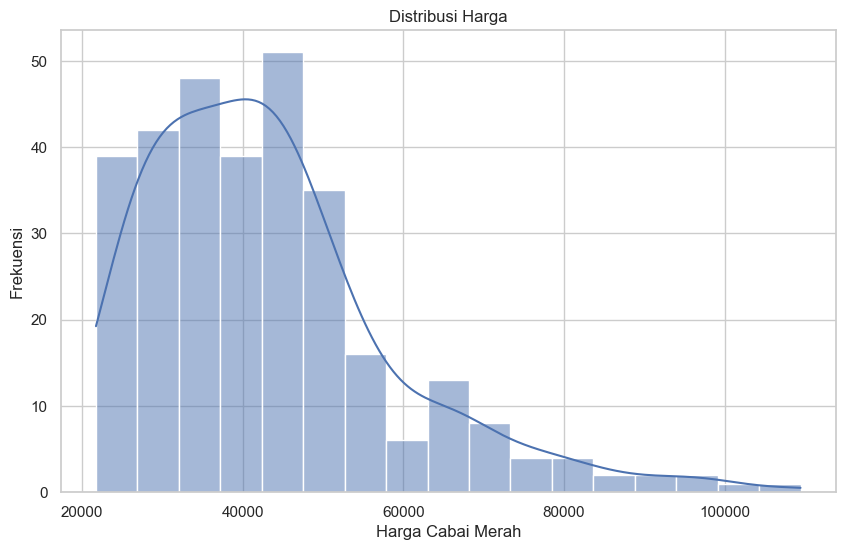

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Harga Cabai Merah'], kde=True)
plt.title('Distribusi Harga')
plt.xlabel('Harga Cabai Merah')
plt.ylabel('Frekuensi')
plt.show()

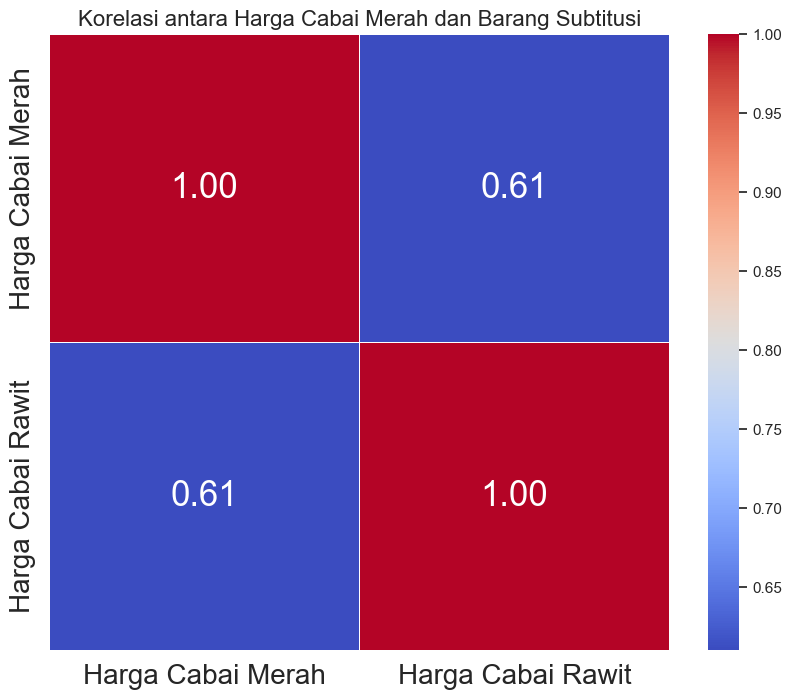

In [75]:
corr_with_target = df[['Harga Cabai Merah','Harga Cabai Rawit']].corr()
# Membuat heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5,
                      annot_kws={"size": 25})  # Ukuran font diperbesar menjadi 25

# Memperbesar ukuran font label pada sumbu x dan y
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)

# Menambahkan judul
plt.title('Korelasi antara Harga Cabai Merah dan Barang Subtitusi', fontsize=16)

# Menampilkan heatmap
plt.show()

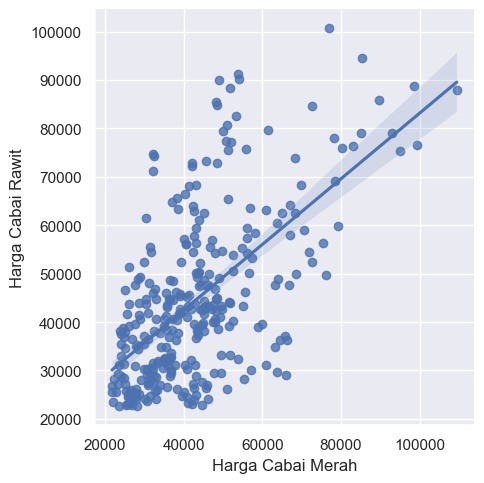

In [76]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
df.head()
sns.lmplot(x="Harga Cabai Merah", y="Harga Cabai Rawit", data=df)
plt.show()

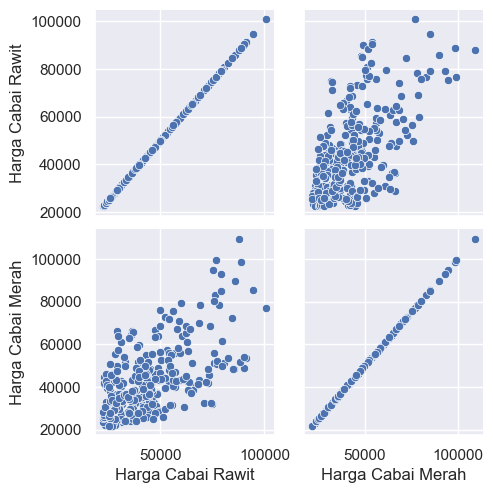

In [77]:
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.pairplot(df, diag_kind=None)
plt.show()

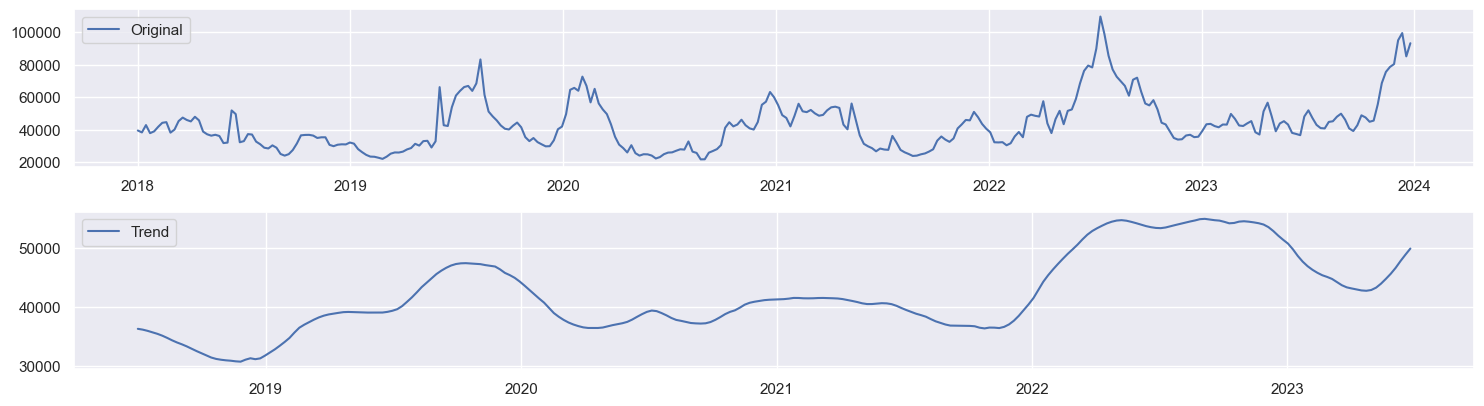

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ubah kolom 'Tanggal' menjadi tipe datetime dan tetapkan sebagai indeks
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
df.set_index('Tanggal', inplace=True)

# Melakukan dekomposisi musiman
decomposition = seasonal_decompose(df['Harga Cabai Merah'], model='additive')

# Menampilkan hasil
plt.figure(figsize=(15, 8))

# Data asli
plt.subplot(411)
plt.plot(df.index, df['Harga Cabai Merah'], label='Original')
plt.legend(loc='upper left')

# Trend
plt.subplot(412)
plt.plot(decomposition.trend.index, decomposition.trend, label='Trend')
plt.legend(loc='upper left')


plt.tight_layout()
plt.show()


# Preprocessing Data


In [79]:
scaler_rr = MinMaxScaler(feature_range=(0, 1))
scaler_harga = MinMaxScaler(feature_range=(0, 1))
df['Harga Cabai Merah_Scaled'] = scaler_harga.fit_transform(df[['Harga Cabai Merah']])
df['Harga Cabai Rawit_Scaled'] = scaler_rr.fit_transform(df[['Harga Cabai Rawit']])

In [80]:
df.head()

,Harga Cabai Rawit,Harga Cabai Merah,Bulan,Harga Cabai Merah_Scaled,Harga Cabai Rawit_Scaled
Tanggal,,,,,
2018-01-01,24750.000000,39475.0,2018-01,0.202109,0.027511
2018-01-08,26200.000000,38300.0,2018-01,0.188712,0.046065
2018-01-15,31183.333333,42800.0,2018-01,0.240023,0.109832
2018-01-22,31183.333333,37850.0,2018-01,0.183580,0.109832
2018-01-29,42600.000000,38950.0,2018-01,0.196123,0.255918


# Split Data

In [81]:
selected_columns = ['Harga Cabai Merah_Scaled','Harga Cabai Rawit_Scaled']
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)][selected_columns].values
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back + 1]['Harga Cabai Merah_Scaled'].values)
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], len(selected_columns)))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], len(selected_columns)))

# Pembuatan Model

In [82]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 2), activation='relu'))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(trainX, trainY, epochs=110, batch_size=8, verbose=2,validation_split=0.2)

Epoch 1/110
25/25 - 2s - loss: 0.0473 - val_loss: 0.1430 - 2s/epoch - 96ms/step
Epoch 2/110
25/25 - 0s - loss: 0.0289 - val_loss: 0.0892 - 77ms/epoch - 3ms/step
Epoch 3/110
25/25 - 0s - loss: 0.0175 - val_loss: 0.0491 - 98ms/epoch - 4ms/step
Epoch 4/110
25/25 - 0s - loss: 0.0149 - val_loss: 0.0442 - 95ms/epoch - 4ms/step
Epoch 5/110
25/25 - 0s - loss: 0.0137 - val_loss: 0.0384 - 76ms/epoch - 3ms/step
Epoch 6/110
25/25 - 0s - loss: 0.0122 - val_loss: 0.0297 - 75ms/epoch - 3ms/step
Epoch 7/110
25/25 - 0s - loss: 0.0110 - val_loss: 0.0240 - 76ms/epoch - 3ms/step
Epoch 8/110
25/25 - 0s - loss: 0.0098 - val_loss: 0.0204 - 75ms/epoch - 3ms/step
Epoch 9/110
25/25 - 0s - loss: 0.0087 - val_loss: 0.0156 - 81ms/epoch - 3ms/step
Epoch 10/110
25/25 - 0s - loss: 0.0078 - val_loss: 0.0118 - 81ms/epoch - 3ms/step
Epoch 11/110
25/25 - 0s - loss: 0.0071 - val_loss: 0.0127 - 83ms/epoch - 3ms/step
Epoch 12/110
25/25 - 0s - loss: 0.0066 - val_loss: 0.0101 - 134ms/epoch - 5ms/step
Epoch 13/110
25/25 - 0s -

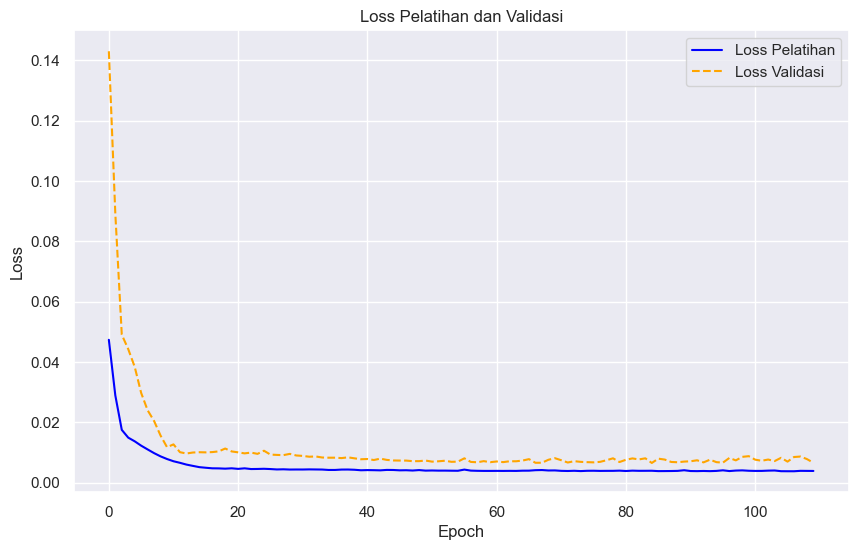

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Misalkan 'history' adalah objek yang didapatkan setelah melatih model
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')  # Jika validasi split digunakan

# Ubah list menjadi array NumPy
train_loss_np = np.array(train_loss)
val_loss_np = np.array(val_loss) if val_loss else None

# Siapkan plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot loss pelatihan
ax.plot(train_loss_np, label='Loss Pelatihan', linestyle='-', color='blue')

# Plot loss validasi (jika tersedia)
if val_loss_np is not None:
    ax.plot(val_loss_np, label='Loss Validasi', linestyle='--', color='orange')

# Label dan judul
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss Pelatihan dan Validasi')

# Legenda
ax.legend()

# Grid (opsional)
ax.grid(True)

# Tampilkan atau simpan plot
plt.show()  # atau plt.savefig('loss_curve.png')

#の説明 ada di komentar di bawah kode


In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 50)             10600     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [85]:
import tensorflow as tf

# Simpan model dalam format .h5
#model.save("lag3.h5")

# Muat kembali model dari file .h5
model = tf.keras.models.load_model("lag3.h5")

# Gunakan model seperti yang Anda butuhkan

In [86]:
predictions = model.predict(testX)
predictions = scaler_harga.inverse_transform(predictions)
testY = scaler_harga.inverse_transform(testY)

2/2 [==============================] - 0s 3ms/step


In [87]:
trainY = scaler_harga.inverse_transform(trainY)

In [88]:
df_test = pd.DataFrame({'Actual': np.squeeze(testY), 'Predicted': np.squeeze(predictions)})
df_test.head(30)

,Actual,Predicted
0,44250.0,51399.394531
1,43200.0,44878.632812
2,39000.0,44100.042969
3,34900.0,40427.109375
4,33900.0,36578.308594
5,34100.0,35656.183594
6,36400.0,36181.015625
7,36850.0,38972.054688
8,35400.0,39347.808594
9,35650.0,37618.425781


In [89]:
#df['Tanggal'] = pd.to_datetime(df['Tanggal'])
#df.set_index('Tanggal', inplace=True)
#df.sort_index(inplace=True)
#df.index = pd.to_datetime(df.index)

# Hasil Akhir

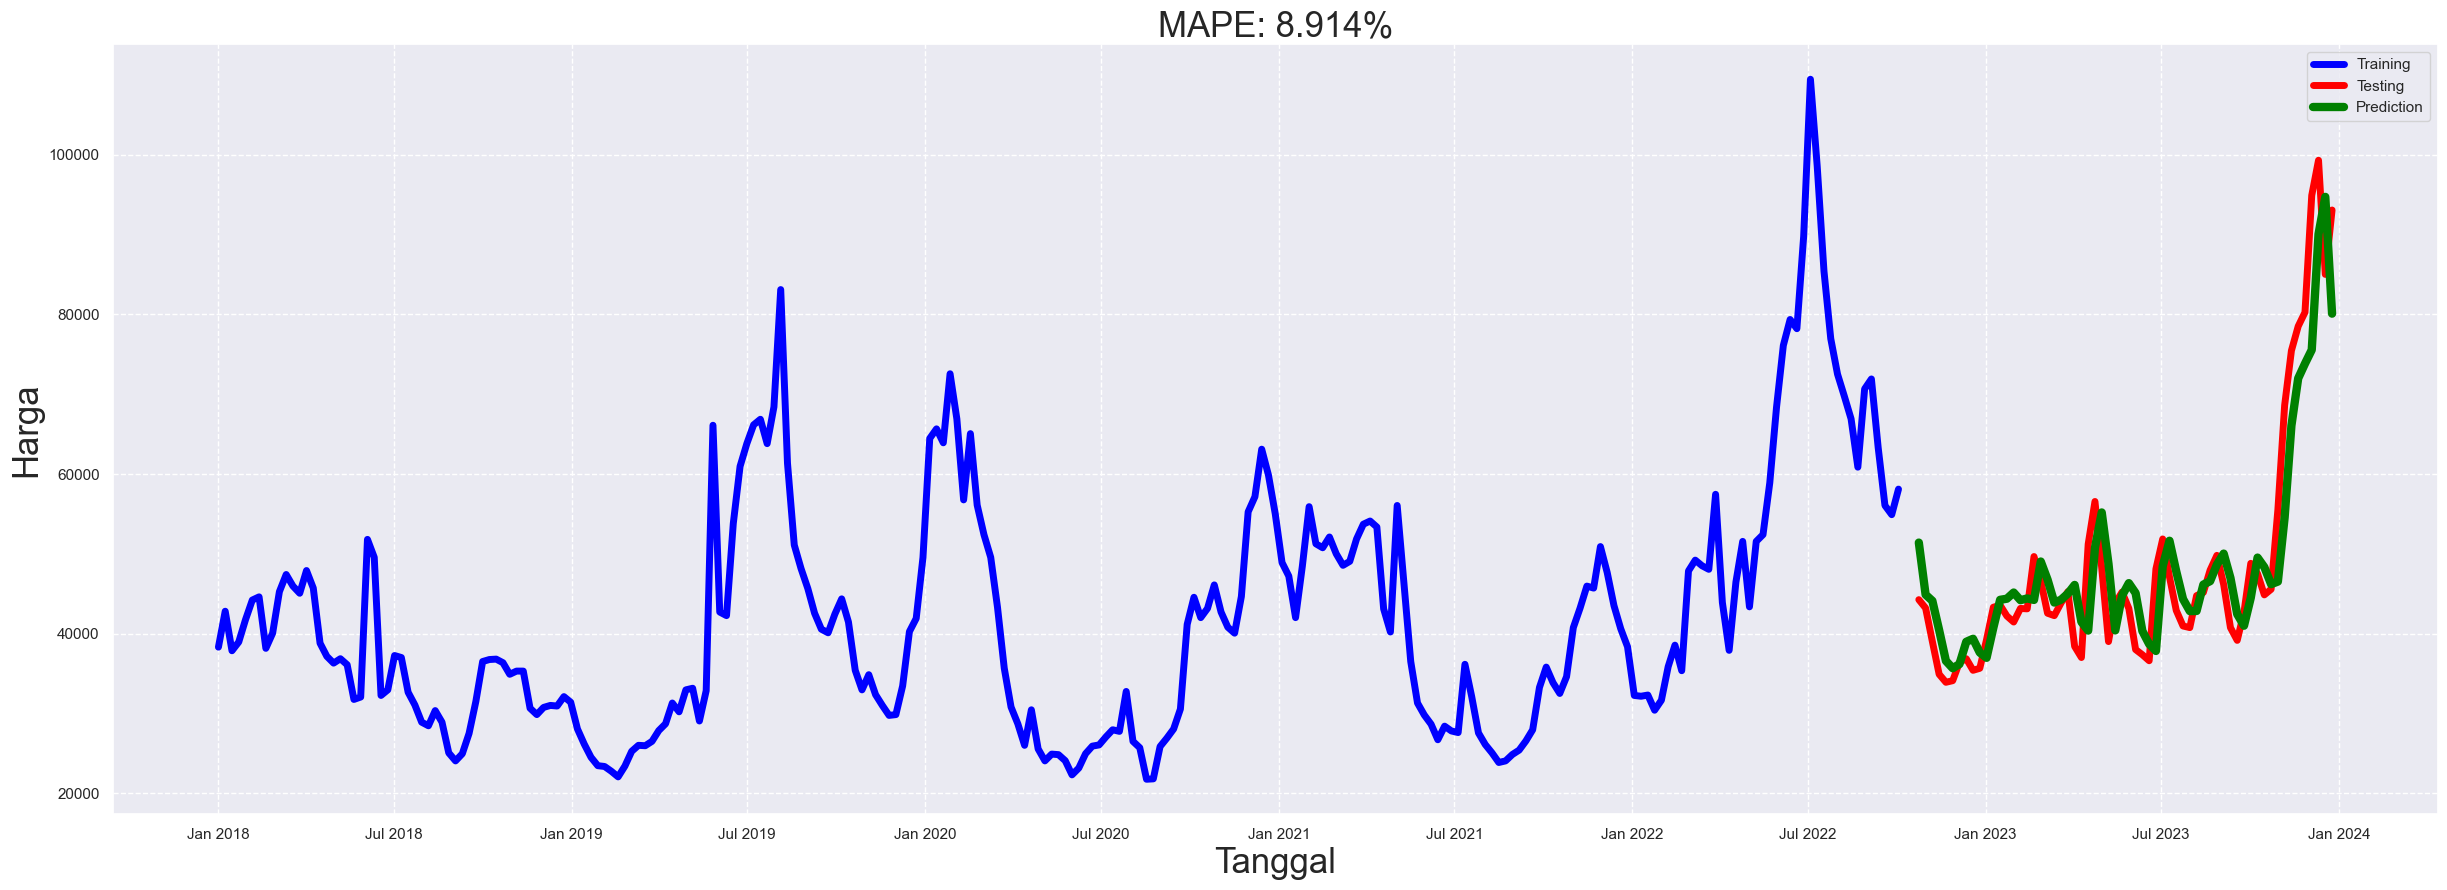

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.dates import MonthLocator, DateFormatter
mape = mean_absolute_percentage_error(testY, predictions)*100

plt.figure(figsize=(30, 10))
plt.plot(df.index[:len(trainY)], trainY, label='Training', marker='', color='blue', linestyle='-', linewidth=5)
plt.plot(df.index[-len(testY):], testY, label='Testing', marker='', color='red', linestyle='-', linewidth=5)
plt.plot(df.index[-len(predictions):], predictions, label='Prediction', marker='', color='green', linestyle='-', linewidth=6)
plt.title(f'MAPE: {mape:.3f}%', fontsize=25)
plt.xlabel('Tanggal', fontsize=25)
plt.ylabel('Harga', fontsize=25)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()

locator = MonthLocator(bymonth=[1, 7])
formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.show()
